# Rule-based text classifcation using keywords

IMPORT LABRARIES

In [41]:
import re
import string
import numpy as np
from itertools import repeat
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


DOWNLOAD NLTK REQUIREMENTS

In [42]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [43]:
lemmatizer = WordNetLemmatizer()

In [72]:
import numpy as np
from collections import defaultdict
from nltk.corpus import wordnet  # Make sure WordNet is installed

def expand_keywords(keywords):
    # Expand keywords using WordNet synonyms
    expanded = set(keywords)
    for word in keywords:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                expanded.add(lemma.name().replace("_", " "))
    return list(expanded)

def expand_keyword_dict(keyword_dict):
    # Expand all keyword categories
    return {cat: expand_keywords(keys) for cat, keys in keyword_dict.items()}

def preprocess_text(text):
    # Tokenize and preprocess text
    tokens = text.lower().split()
    return tokens

def score_text(tokens, keys):
    # Score tokens against keyword list
    score = sum(1 for token in tokens if token in keys)
    return score

def apply_negation(tokens, base_score):
    # Apply negation modifiers to score
    negation_words = {"not", "no", "never", "don't", "doesn't", "didn't"}
    negation_count = sum(1 for token in tokens if token in negation_words)
    adjusted_score = max(0, base_score - negation_count)
    return adjusted_score

def classify_text(text, keyword_dict):
    # Classify text based on keyword matching
    tokens = preprocess_text(text)
    expanded = expand_keyword_dict(keyword_dict)

    scores = defaultdict(int)

    for cat, keys in expanded.items():
        base = score_text(tokens, keys)
        final = apply_negation(tokens, base)
        scores[cat] = final

    values = np.array(list(scores.values()))
    keys = np.array(list(scores.keys()))

    max_val = np.max(values)
    if max_val == 0:
        return "unknown", dict(scores)

    winners = keys[values == max_val]
    return (winners[0] if len(winners) == 1 else winners.tolist(), dict(scores))


SAMPLE DATASET

In [56]:
data = [
    "The football match was thrilling.",
    "The president introduced a new policy.",
    "AI and software are changing the world.",
    "The doctor recommended the vaccine.",
    "Bank investments crashed today.",
    "Students prepared for their exams."
]

In [57]:
labels = [
    "sports",
    "politics",
    "technology",
    "health",
    "finance",
    "education"
]


 VISUALIZATION 1: WORD DISTRIBUTION (FreqDist)

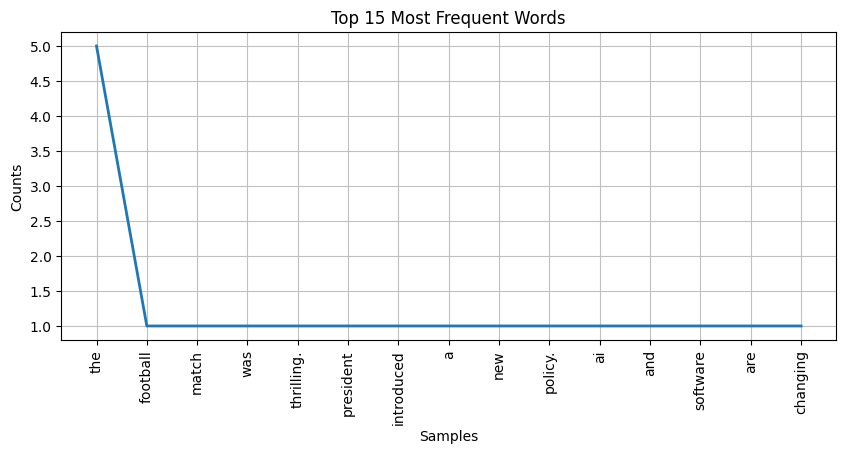

In [58]:
fd = FreqDist(" ".join(data).lower().split())

plt.figure(figsize=(10, 4))
fd.plot(15, title="Top 15 Most Frequent Words")
plt.show()

TRAIN / TEST SPLIT AND ENCODING

In [59]:
label_encoder = preprocessing.LabelEncoder()
y_enc = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    data, y_enc, test_size=0.33, random_state=42
)

 PREDICTION

In [60]:
import nltk
nltk.download("punkt_tab")

preds = []
for _ in repeat(None, len(X_test)):
    idx = len(preds)
    raw = X_test[idx]
    pred, _ = classify_text(raw, keyword_dict)

    if isinstance(pred, list):
        pred = pred[0]

    preds.append(pred)

pred_enc = label_encoder.transform(preds)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


CLASSIFICATION REPORT

In [70]:
from sklearn.metrics import classification_report

print("  RULE-BASED CLASSIFICATION REPORT")
print(classification_report(
    y_test,
    pred_enc,
    labels=label_encoder.transform(label_encoder.classes_),
    target_names=label_encoder.classes_,
    zero_division=0  # Show 0 for missing classes instead of error
))


  RULE-BASED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   education       0.00      0.00      0.00         0
     finance       0.00      0.00      0.00         0
      health       0.00      0.00      0.00         0
    politics       1.00      1.00      1.00         1
      sports       1.00      1.00      1.00         1
  technology       0.00      0.00      0.00         0

    accuracy                           1.00         2
   macro avg       0.33      0.33      0.33         2
weighted avg       1.00      1.00      1.00         2



VISUALIZATION 2: CONFUSION MATRIX HEATMAP

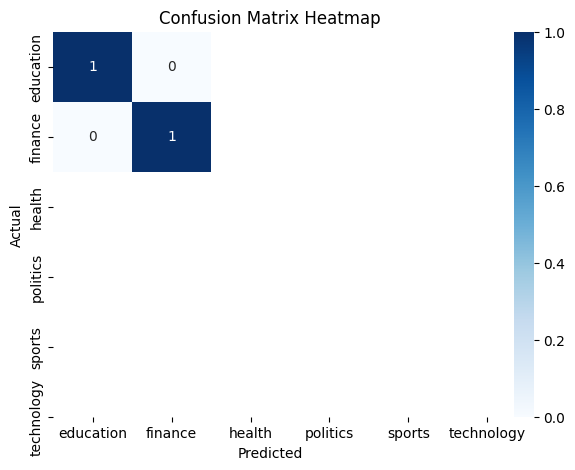

In [69]:
cm = confusion_matrix(y_test, pred_enc)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


VISUALIZATION 3: CATEGORY BAR CHART

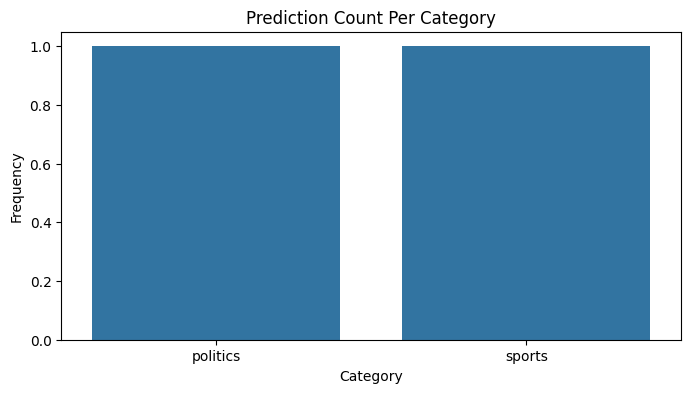

In [64]:
unique, freq = np.unique(preds, return_counts=True)

plt.figure(figsize=(8, 4))
sns.barplot(x=unique, y=freq)
plt.title("Prediction Count Per Category")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.show()

FEATURE EXTRACTION (CountVectorizer)

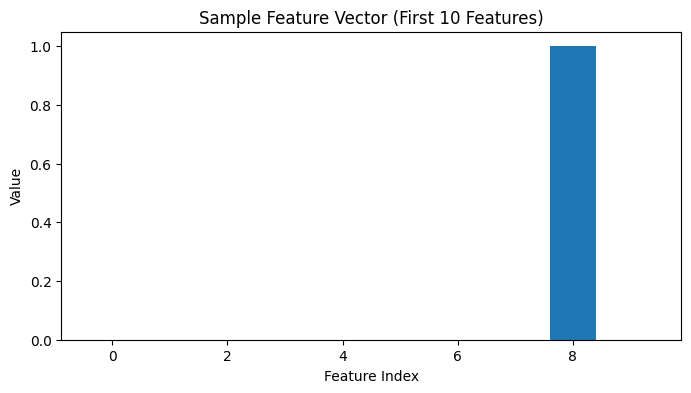

In [65]:
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(data)

plt.figure(figsize=(8, 4))
plt.bar(range(10), X_vec.toarray()[0][:10])
plt.title("Sample Feature Vector (First 10 Features)")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.show()

TEST MODEL ON NEW SAMPLES

In [66]:
tests = [
    "The senate passed a new election bill.",
    "AI is revolutionizing automation.",
    "Crypto investments are rising.",
    "The doctor examined the patient.",
    "Students are preparing for mathematics exams."
]

In [71]:

print(" NEW SAMPLE PREDICTIONS")

for t in tests:
    pred, scores = classify_text(t, keyword_dict)
    print("\nText:", t)
    print("Prediction:", pred)
    print("Scores:", scores)

 NEW SAMPLE PREDICTIONS

Text: The senate passed a new election bill.
Prediction: politics
Scores: {'sports': 0, 'politics': 2, 'technology': 0, 'health': 0, 'finance': 0, 'education': 0}

Text: AI is revolutionizing automation.
Prediction: technology
Scores: {'sports': 0, 'politics': 0, 'technology': 1, 'health': 0, 'finance': 0, 'education': 0}

Text: Crypto investments are rising.
Prediction: finance
Scores: {'sports': 0, 'politics': 0, 'technology': 0, 'health': 0, 'finance': 1, 'education': 0}

Text: The doctor examined the patient.
Prediction: health
Scores: {'sports': 0, 'politics': 0, 'technology': 0, 'health': 1, 'finance': 0, 'education': 0}

Text: Students are preparing for mathematics exams.
Prediction: unknown
Scores: {'sports': 0, 'politics': 0, 'technology': 0, 'health': 0, 'finance': 0, 'education': 0}
